In [32]:
import LowLevelFEM as FEM
using LowLevelFEM

gmsh.initialize()

In [33]:
using SparseArrays
using Plots

In [34]:
gmsh.open("dynamic_energy_2.geo");

Info    : Reading 'dynamic_energy_2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Circle)
Info    : [ 90%] Meshing curve 9 (Circle)
Info    : Done meshing 1D (Wall 0.000483613s, CPU 0.000358s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 40%] Blossom: 125 internal 50 closed
Info    : [ 40%] Blossom recombination completed (Wall 0.00747348s, CPU 0.005064s): 50 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.887941, min Q = 0.874171
Info    : [ 70%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0706444s, CPU 0.053663s)
Info    : 3

In [35]:
#mat = FEM.material("body")
mat1 = FEM.material("Fe", E=1.96e5, ν=0.25, ρ=7.874e-9)
mat2 = FEM.material("Al", E=7e4, ν=0.334, ρ=2.7e-9)
problem = FEM.Problem([mat1, mat2], type="PlaneStress")
#problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 27)


LowLevelFEM.Problem("dynamic_energy_2", "PlaneStress", 2, [("Fe", 196000.0, 0.25, 7.874e-9), ("Al", 70000.0, 0.334, 2.7e-9)], 1.0, 323)

In [36]:
load = FEM.load("right", fx=-1);

In [37]:
K = FEM.stiffnessMatrix(problem);

In [38]:
M = FEM.massMatrix(problem, lumped=true);

In [39]:
f = FEM.loadVector(problem, [load]);

In [40]:
dof = problem.non * problem.dim;

u0 = zeros(dof);
v0 = zeros(dof);

#display(u0)
#display(v0)


646-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [41]:
C = spzeros(dof, dof);

In [43]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

1.1668011903408871e-7

In [44]:
n = 100; # egy lépéssel kevesebb lesz végül az átfedés miatt!

u = zeros(dof, n - 1);
v = zeros(dof, n - 1);
t = zeros(n - 1);

terhelt = 4;
terheletlen = n - terhelt;

u_1, v_1, t_1 = FEM.CDM(K, M, C, f, u0, v0, terhelt * Tₘᵢₙ / π / 1, Tₘᵢₙ / π / 1);




u_1_kezdo = u_1[:, terhelt];
v_1_kezdo = v_1[:, terhelt];


#display(K)
#display(M)
#display(C)
#display(f)
#display(u_1_kezdo)
#display(v_1_kezdo)
#display(terheletlen)
#display(Tₘᵢₙ)




u_2, v_2, t_2 = FEM.CDM(K, M, C, f, u_1_kezdo, v_1_kezdo, terheletlen * Tₘᵢₙ / π / 1, Tₘᵢₙ / π / 1);



t_eltolas = t_1[terhelt];
t_2 .+= t_eltolas;

u[:, 1:terhelt] = u_1;
u[:, terhelt:n-1] = u_2;

v[:, 1:terhelt] = v_1;
v[:, terhelt:n-1] = v_2;

t[1:terhelt] = t_1;
t[terhelt:n-1] = t_2;

DimensionMismatch: DimensionMismatch: tried to assign 646×97 array to 646×96 destination

In [47]:
S = FEM.solveStress(problem, u);

In [48]:
s = FEM.showStressResults(problem, S, "s", t=t, name="σred", visible=true, smooth=false)

4

In [49]:
uvec = FEM.showDoFResults(problem, u, "uvec", t=t, name="u", visible=false)

5

In [50]:
vvec = FEM.showDoFResults(problem, v, "vvec", t=t, name="v", visible=false)

6

In [51]:
Wi = [(u[:, i] - u[:, i-1])' * f for i in 2:n-1]
W = sum(Wi)

6.776263578034403e-21

In [52]:
U = u[:, n-1]' * K * u[:, n-1] / 2 + v[:, n-1]' * M * v[:, n-1] / 2

0.0

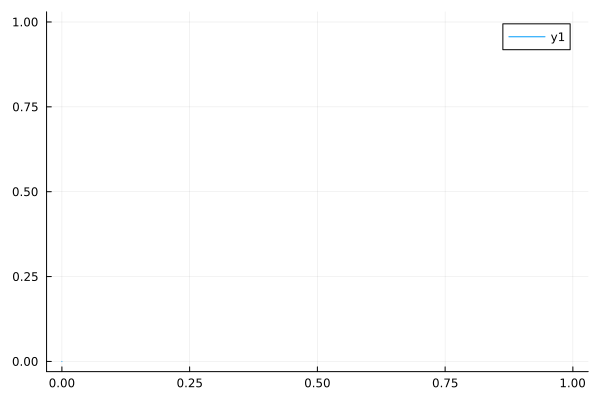

In [53]:
h = 5
np = 10
q = 0
X = 14.999
#display(t)
q_1 = zeros(n - 1, 1);
for j ∈ 2:n-1
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q_1[n-1, 1] = [1, 0, 0]' * ss * vv * ΔA * Δt
        q += [1, 0, 0]' * ss * vv * ΔA * Δt

    end
end
#display(q_1)
q
plot(t, q_1)

In [54]:
(U - W) / U * 100

-Inf

In [55]:
(U - q) / U * 100

NaN

In [56]:
(W - q) / W * 100

100.0

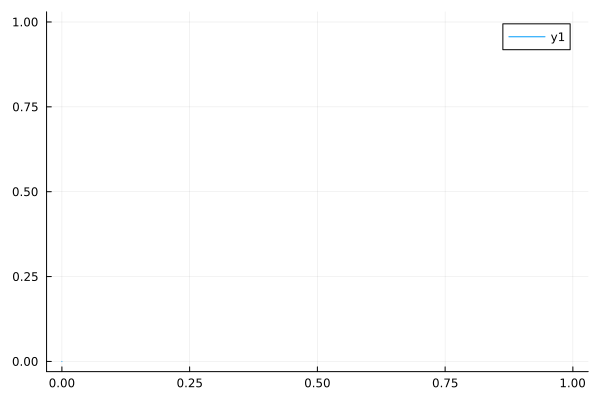

In [57]:
h = 5
np = 10
q = 0
X = 9.999
#display(t)
q_2 = zeros(n - 1, 1);
for j ∈ 2:n-1
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q_2[n-1, 1] = [1, 0, 0]' * ss * vv * ΔA * Δt
        q += [1, 0, 0]' * ss * vv * ΔA * Δt

    end
end
#display(q_2)
q
plot(t, q_2)

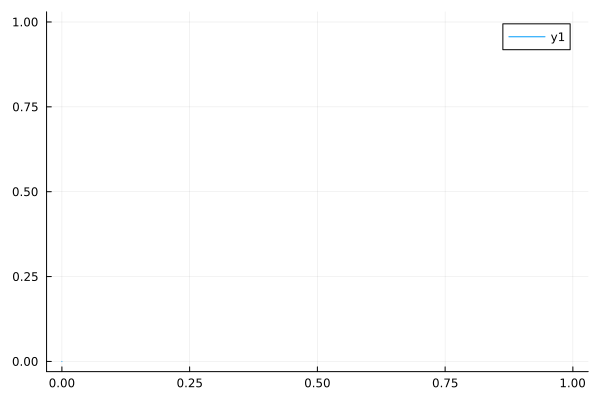

In [58]:
h = 5
np = 10
q = 0
X = 0.001
#display(t)
q_3 = zeros(n - 1, 1);
for j ∈ 2:n-1
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q_2[n-1, 1] = [1, 0, 0]' * ss * vv * ΔA * Δt
        q += [1, 0, 0]' * ss * vv * ΔA * Δt

    end
end
#display(q_3)
q
plot(t, q_3)

In [59]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.6.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XRequest.18: BadValue 0x0


In [60]:
gmsh.finalize()